# Visualizing distributions of data

This notebook demonstrates different approaches to graphically representing distributions of data, specifically focusing on the tools provided by the [seaborn](https://github.com/mwaskom/seaborn) package.

Originally from https://nbviewer.jupyter.org/github/olgabot/seaborn/blob/violin_improvements/examples/plotting_distributions.ipynb, but presented here since it is no longer maintained.

In [1]:
import numpy as np
from numpy.random import randn
import pandas as pd
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_color_palette("deep", desat=.6)
mpl.rc("figure", figsize=(8, 4))
np.random.seed(9221999)

## Basic visualization with histograms

The most basic and common way of representing a distributions is with a histogram. We can do this directly through the `hist` function that is part of matplotlib.

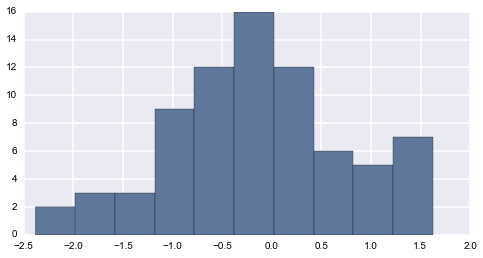

In [3]:
data = randn(75)
plt.hist(data);

By default, `hist` separates the data into 10 bins of equal widths and plots the number of observations in each bin. Thus, the main parameter is the number of bins, which we can change.

The more bins you have, the more sensitive you will be to high-frequency patterns in the distribution. But, sometimes those high-frequency patterns will be noise. Often you want to try different values until you think you have best captured what you see in the data.

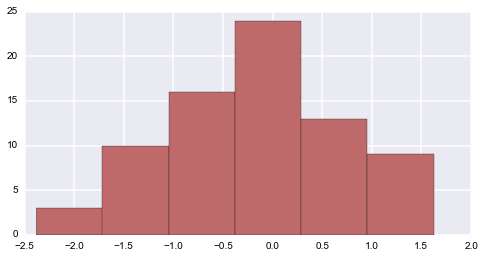

In [4]:
plt.hist(data, 6, color=sns.desaturate("indianred", .75));

The `normed` argument can also be useful if you want to compare two distributions that do not have the same number of observations.

Note also that `bins` can be a sequence of where each bin starts.

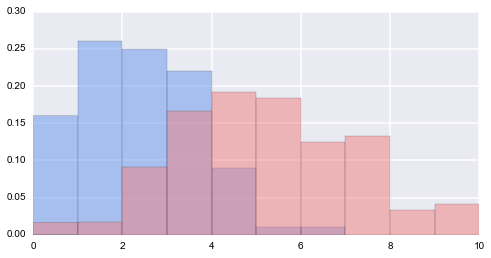

In [5]:
data1 = stats.poisson(2).rvs(100)
data2 = stats.poisson(5).rvs(120)
max_data = np.r_[data1, data2].max()
bins = np.linspace(0, max_data, max_data + 1)
plt.hist(data1, bins, normed=True, color="#6495ED", alpha=.5)
plt.hist(data2, bins, normed=True, color="#F08080", alpha=.5);

The `hist` function has quite a few other options, which you can explore in its docstring. Here we'll just highlight one more that can be useful when plotting many observations (such as following a resampling procedure).

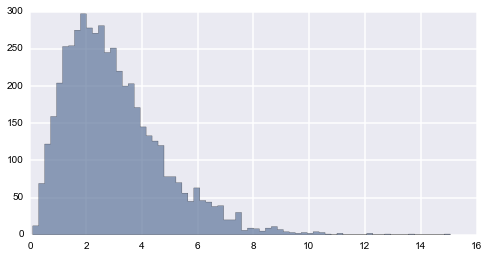

In [6]:
data = stats.gamma(3).rvs(5000)
plt.hist(data, 70, histtype="stepfilled", alpha=.7);

You can also represent a joint distribution with the histogram method. Here we will plot a 2D matrix and color-encode the counts (or mass).

At the moment it is mildly cumbersome to do this manually; I may include a function that wraps up these steps in Seaborn.

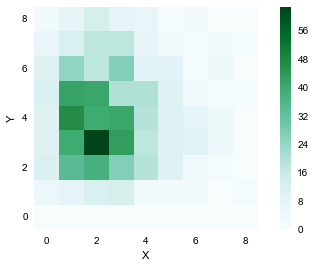

In [7]:
x = stats.gamma(3).rvs(1000)
y = stats.gamma(5).rvs(1000)
vals, binx, biny = np.histogram2d(x, y, range(10))
plt.imshow(vals.T, interpolation="nearest", cmap="BuGn", origin="lower", zorder=1)
sns.axlabel("X", "Y")
plt.colorbar();

## Estimating the density of the observations: `kdeplot` and `rugplot`

A superior, if more computationally intensive, approach to estimating a distribution is known as a kernel density estimate, or KDE. To motivate the KDE, let's first think about rug plots. A rug plot is a very simple, but also perfectly legitimate, way of representing a distribution. To create one, simply draw a vertical line at each observed data point. Here, the height is totally arbitrary.

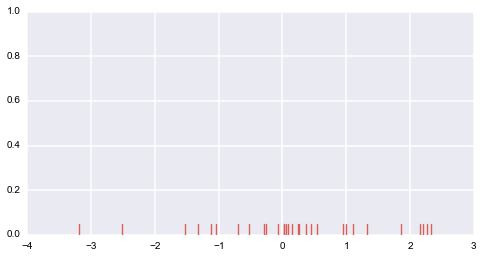

In [8]:
sns.set_color_palette("hls", 1)
data = randn(30)
sns.rugplot(data)
plt.ylim(0, 1);

You can see where the density of the distribution is by how dense the tick-marks are. Before talking about kernel density plots, let's connect the rug plot to the histogram. The connection here is very direct: a histogram just creates bins along the range of the data and then draws a bar with height equal to the number of ticks in each bin

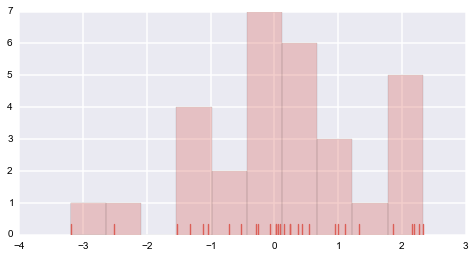

In [9]:
plt.hist(data, alpha=.3)
sns.rugplot(data);

A kernel density plot is also a transformation from the tick marks to a height-encoded measure of density. However, the transformaiton is a bit more complicated. Instead of binning each tick mark, we will instead represent each tick with a gaussian basis function.

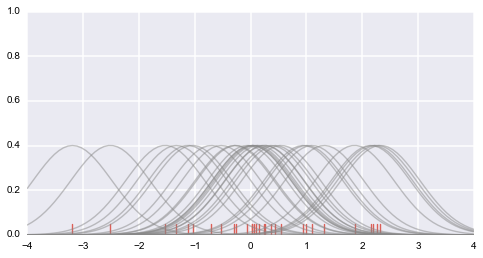

In [10]:
# Draw the rug and set up the x-axis space
sns.rugplot(data);
xx = np.linspace(-4, 4, 100)

# Compute the bandwidth of the kernel using an optimal formula
bandwidth = ((4 * data.std() ** 5) / (3 * len(data))) ** .2

# We'll save the basis functions for the next step
kernels = []

# Plot each basis function
for d in data:
    
    # Make the basis function as a gaussian PDF
    kernel = stats.norm(d, bandwidth).pdf(xx)
    kernels.append(kernel)
    
    # Scale for plotting
    kernel /= kernel.max()
    kernel *= .4
    plt.plot(xx, kernel, "#888888", alpha=.5)
plt.ylim(0, 1);

We then estimate the distribution that our samples came from from by summing these basis functions (and normalizing so, as a proper density, the function integrates to 1).

There is also a function in the `scipy.stats` module that will perform a kernel density estimate (it actually returns an object that can be called on some values to return the density). We see that plotting the values from this object give us basically the same results as summing the gaussian basis functions.

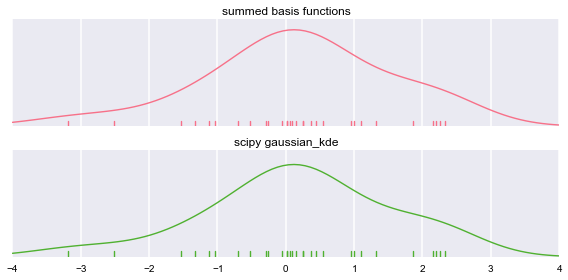

In [11]:
# Set up the plots
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
c1, c2 = sns.color_palette("husl", 3)[:2]

# Plot the summed basis functions
summed_kde = np.sum(kernels, axis=0)
ax1.plot(xx, summed_kde, c=c1)
sns.rugplot(data, c=c1, ax=ax1)
ax1.set_yticks([])
ax1.set_title("summed basis functions")

# Use scipy to get the density estimate
scipy_kde = stats.gaussian_kde(data)(xx)
ax2.plot(xx, scipy_kde, c=c2)
sns.rugplot(data, c=c2, ax=ax2)
ax2.set_yticks([])
ax2.set_title("scipy gaussian_kde")
f.tight_layout()

The seaborn package has a high-level function for plotting a kernel density estimate in one quick step, along with some additional nice features, such as shading in the density.

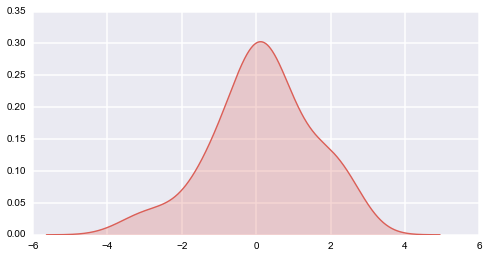

In [12]:
sns.kdeplot(data, shade=True);

As in the case of the histogram, plotting shaded density plots on top of each other can be a good way to ask whether two samples are from the same distribution.

A legend can be helpful when overlaying several densities. This is done either by providing a `label` keyword to `kdeplot`, which explicitly assigns a value to the data, or by inferring the name if you pass an object (like a Pandas Series) with a `name` attribute.

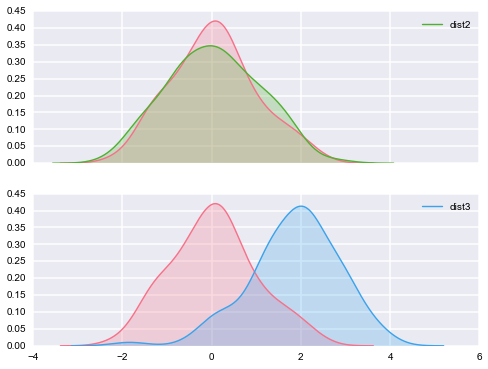

In [13]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
c1, c2, c3 = sns.color_palette("husl", 3)

dist1, dist2, dist3 = stats.norm(0, 1).rvs((3, 100))
dist3 = pd.Series(dist3 + 2, name="dist3")

sns.kdeplot(dist1, shade=True, color=c1, ax=ax1)
sns.kdeplot(dist2, shade=True, color=c2, label="dist2", ax=ax1)

sns.kdeplot(dist1, shade=True, color=c1, ax=ax2)
sns.kdeplot(dist3, shade=True, color=c3, ax=ax2);

If you want the density to be sideways, use the `vertical` keyword.

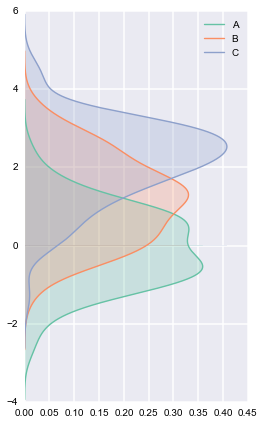

In [14]:
plt.figure(figsize=(4, 7))
data = stats.norm(0, 1).rvs((3, 100)) + np.arange(3)[:, None]

with sns.palette_context("Set2"):
    for d, label in zip(data, list("ABC")):
        sns.kdeplot(d, vertical=True, shade=True, label=label)

Finally, you can also use the kernel density method in a multidimensional case. As with a multidimensional histogram, we will color-encode the density estimate over a 2D space using either filled or unfilled contours.

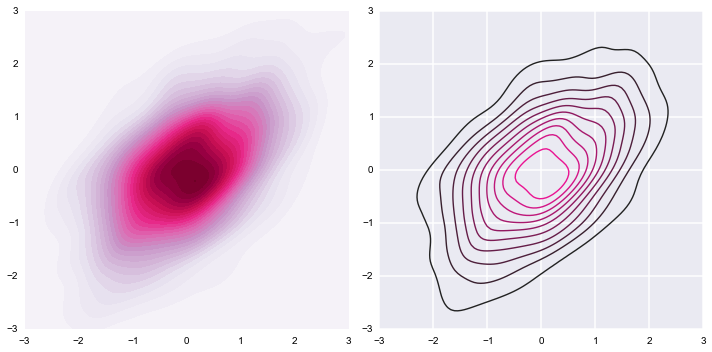

In [15]:
data = np.random.multivariate_normal([0, 0], [[1, .5], [.5, 1]], size=1000)
kde2d = stats.gaussian_kde(data.T)
xx, yy = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
density = kde2d([xx.ravel(), yy.ravel()]).reshape(100, 100)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.contourf(xx, yy, density, 30, cmap="PuRd")
cmap = sns.dark_palette("#EA1493", as_cmap=True)
ax2.contour(xx, yy, density, 10, cmap=cmap)
f.tight_layout()

## Combining plot styles: `distplot`

Each of these styles has advantages and disadvantages. Fortunately, it is easy to combine multiple styles using the `distplot` function in seaborn. `distplot` provides one interface for plotting histograms, kernel density plots, rug plots, and plotting fitted probability distributions.

By default, you'll get a kernel density over a  histogram. Unlike the default matplotlib `hist` function, `distplot` tries to use a good number of bins for the dataset you have, although all of the options for specifying bins in `hist` can be used.

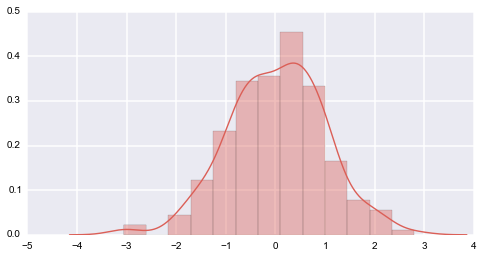

In [16]:
sns.set_color_palette("hls")
data = randn(200)
sns.distplot(data);

`hist`, `kde`, and `rug` are boolean arguments to turn those features on and off.

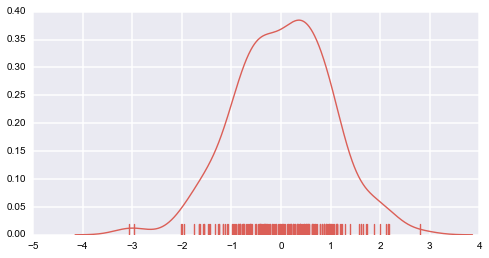

In [17]:
sns.distplot(data, rug=True, hist=False);

You can also pass a distribution family from `scipy.stats`, and `distplot` will fit the parameters using maximum likelihood and plot the resulting function.

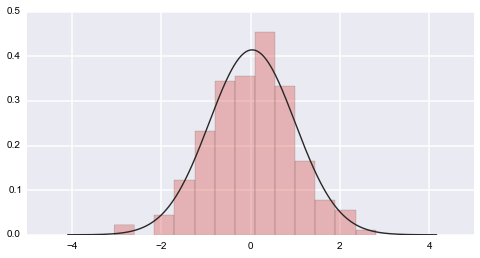

In [18]:
sns.distplot(data, kde=False, fit=stats.norm);

To control any of the underlying plots, pass keyword arguments to the `[plot]_kws` argument.

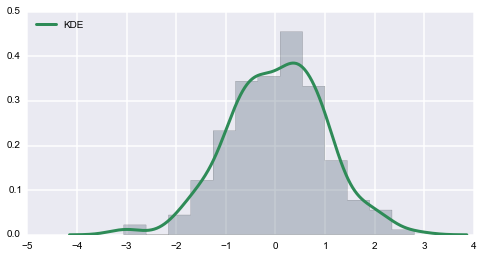

In [19]:
sns.distplot(data,
             kde_kws={"color": "seagreen", "lw": 3, "label": "KDE"},
             hist_kws={"histtype": "stepfilled", "color": "slategray"});

You can also draw the distribution vertically, if for example you wanted to plot marginal distributions on a scatterplot (as in the `regplot` function):

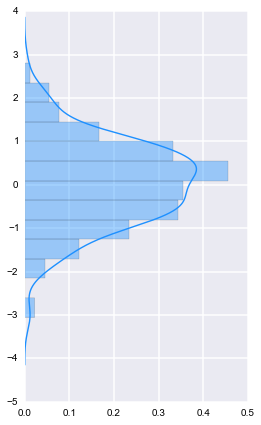

In [20]:
plt.figure(figsize=(4, 7))
sns.distplot(data, color="dodgerblue", vertical=True);

If the data has a `name` attribute (e.g. it is a pandas `Series`), the name will become the xlabel for the plot unless you use `xlabel=False`. You can also provide a string, which will override this behavior and label nameless data.

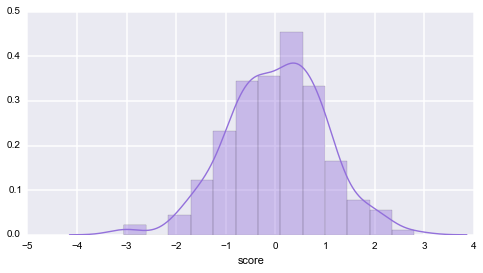

In [21]:
sns.distplot(pd.Series(data, name="score"), color="mediumpurple");

## Comparing distributions: `boxplot` and `violin`

In [22]:
mpl.rc("figure", figsize=(6, 6))

Frequently, you will want to compare two or more distributions. Although above we showed one method to do this above, it's generally better to plot them separately but in the way that allows for easy comparisons.

The traditional approach in this case is to use a boxplot. There is a `boxplot` function in matplotlib we could use...

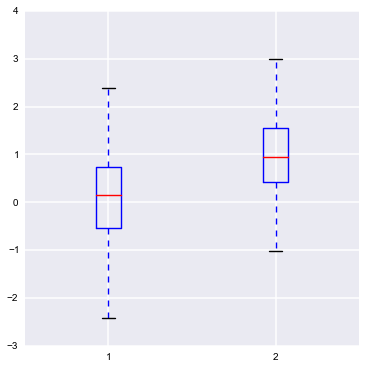

In [23]:
data = [randn(100), randn(100) + 1]
plt.boxplot(data);

...but, it is quite ugly by default. To get more aesthetically pleasing plots, use the `seaborn.boxplot` function:

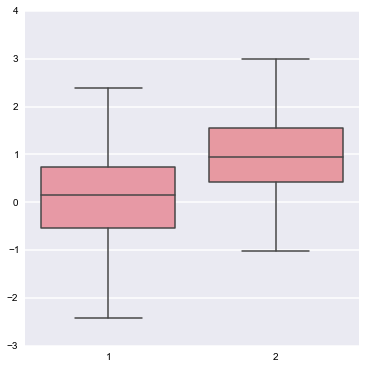

In [24]:
sns.boxplot(data);

The default rules for a boxplot are that the box encompasses the inter-quartile range with the median marked. The "whiskers" extend to 1.5 * IQR past the closest quartile, and any observations outside this range are marked as outliers.

This is quite a mouthfull though, and the outliers can be distracting, so you can just make the whiskers extend all the way out. Let's also tweak the aesthetics a bit.

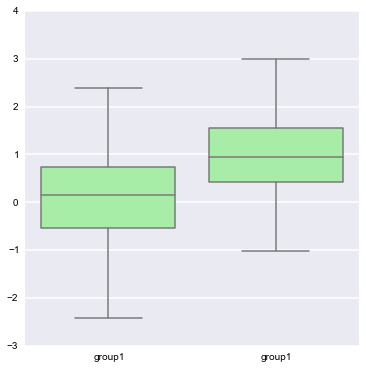

In [25]:
sns.boxplot(data, names=["group1", "group1"], whis=np.inf, color="PaleGreen");

In some cases, you may want to plot repeated-measures data. In this case, a subtle effect that is consistent across subjects can be masked and look non-consequential.

To show such an effect, use the `join_rm` argument.

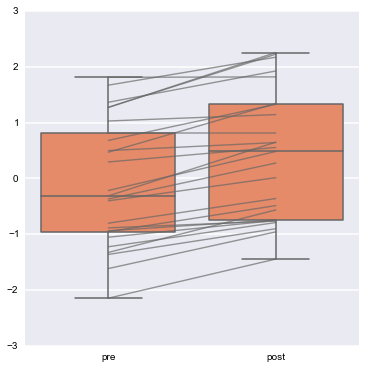

In [26]:
pre = randn(25)
post = pre + np.random.rand(25)
sns.boxplot([pre, post], names=["pre", "post"], color="coral", join_rm=True);

The boxplot is more informative than a bar plot, but it still compresses the a distribution to about five points. Just as the kernel density plot is a modern alternative to the histogram, we can use our computing power to bring more information using a kernel density estimate to these comparative plots.

These plots are known as "violin" (apparently, sometimes "viola") plots. They essentially combine a boxplot with a kernel density estimate.

Let's create a toy case that demonstrates why we might prefer the increased information in the violin plot.

In [27]:
d1 = stats.norm(0, 5).rvs(100)
d2 = np.concatenate([stats.gamma(4).rvs(50),
                     -1 * stats.gamma(4).rvs(50)])
data = pd.DataFrame(dict(d1=d1, d2=d2))

First, draw a boxplot. Note that the `color` argument can take anything that can be used as a palette in addition to any single valid matplotlib color, and that the function is Pandas-aware and will try to label the axes appropriately.

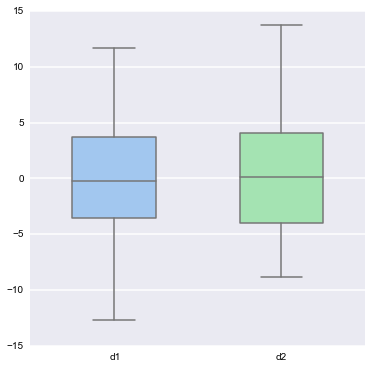

In [28]:
sns.boxplot(data, color="pastel", widths=.5);

Based on this plot, it looks like we basically have two samples from the same distribution.

But, let's just see what the violin plot looks like:

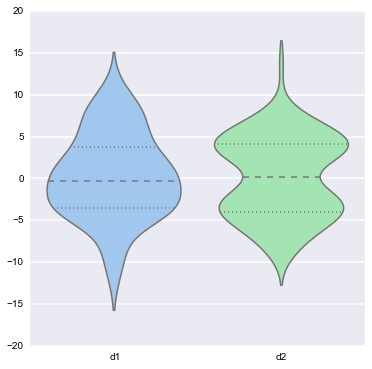

In [29]:
sns.violin(data, color="pastel");

Woah! Now it looks like the distribution on the left is roughly normal, but the distribution on the right is bimodal with peaks at $+/-$ 5.

It may be rare to run into such data, but more information doesn't hurt even in non-pathological cases, and might catch problems that otherwise could slip through.

(Of course, if you looked at each distribution with a histogram/KDE plot as above, you might have caught this before making any comparisons.)

Both the boxplot and violin functions can take a Pandas Series object as the data and an object that can be used to perform a `groupby` on the data to group it into the boxes/violins.

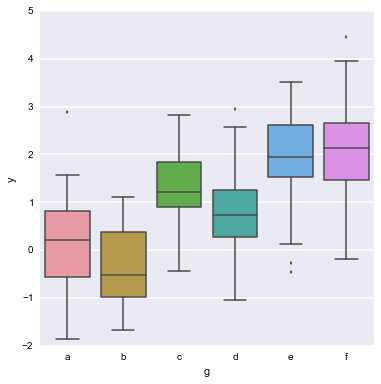

In [30]:
y = np.random.randn(200)
g = np.random.choice(list("abcdef"), 200)
for i, l in enumerate("abcdef"):
    y[g == l] += i / 2
df = pd.DataFrame(dict(y=y, g=g))
sns.boxplot(df.y, df.g);

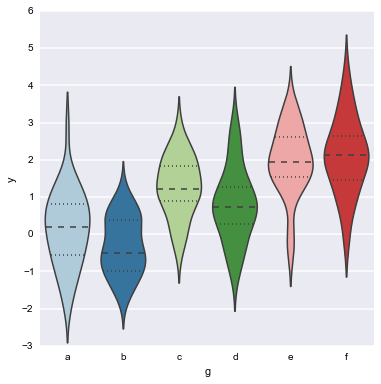

In [31]:
sns.violin(df.y, df.g, color="Paired");

The violin plot by default plots the median, along with the 25th and 75th percentile -- the same information we get from the boxplot. There are, however, other options. You might want to plot each observation (similar to what we do with a rug plot under a KDE). There are two ways to accomplish this.

In [32]:
data = pd.melt(data.ix[:50], value_name="y", var_name="group")

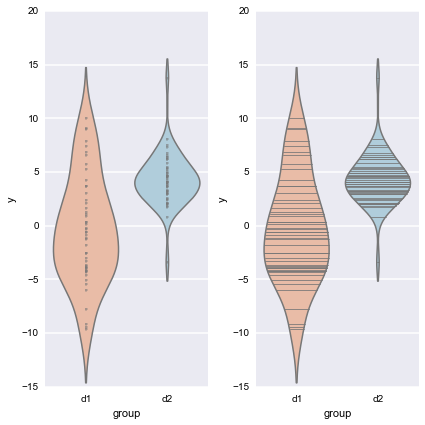

In [33]:
f, (ax_l, ax_r) = plt.subplots(1, 2)
sns.violin(data.y, data.group, "points", positions=[1, 2], color="RdBu", ax=ax_l)
sns.violin(data.y, data.group, "stick", positions=[3, 4], color="RdBu", ax=ax_r)
plt.tight_layout()

Of course, you can plot repeated-measures data with the violin as well.

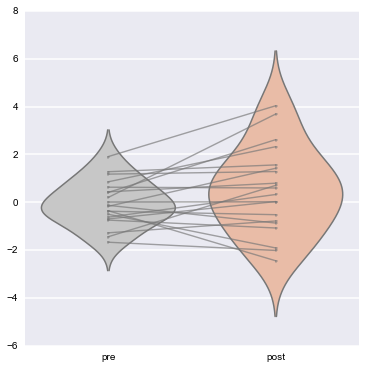

In [34]:
pre = randn(20)
data = pd.DataFrame(dict(pre=pre, post=pre + 1 + randn(20)), columns=["pre", "post"])
sns.violin(data, inner="points", join_rm=True, color="RdGy_r");

Using a palette colorscheme can be particularly useful if you have many bins.

In [35]:
mpl.rc("figure", figsize=(9, 6))

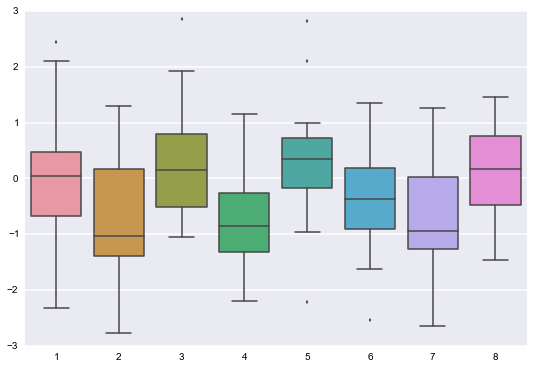

In [36]:
data = randn(30, 8) + (np.random.rand(8) * 2 - 1)
sns.boxplot(data);

Chose the color scheme carefully! The above is good for categorigal bins, but perhaps there is some ordering to the grouping variable:

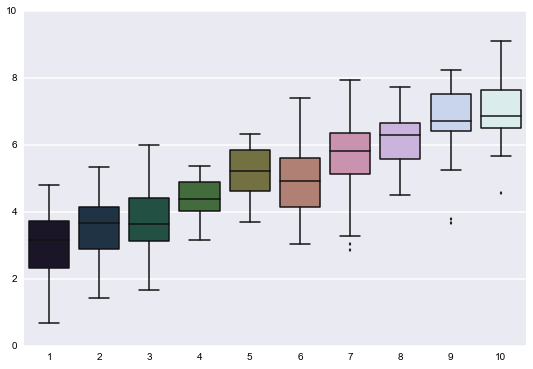

In [37]:
data = randn(30, 10) + np.linspace(3, 7, 10)
sns.boxplot(data, widths=.8, color="cubehelix");

Different kinds of relationships lend themselves to different kinds of color palettes:

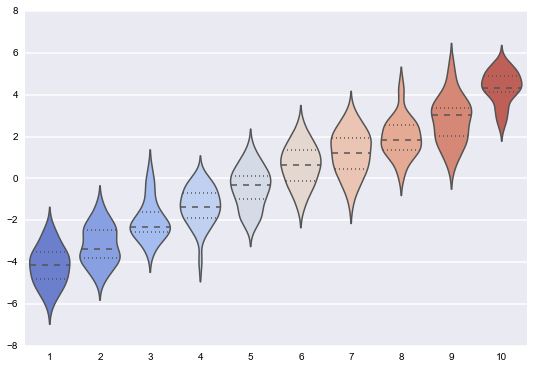

In [38]:
data = randn(30, 10) + np.linspace(-4, 4, 10)
sns.violin(data, color="coolwarm");

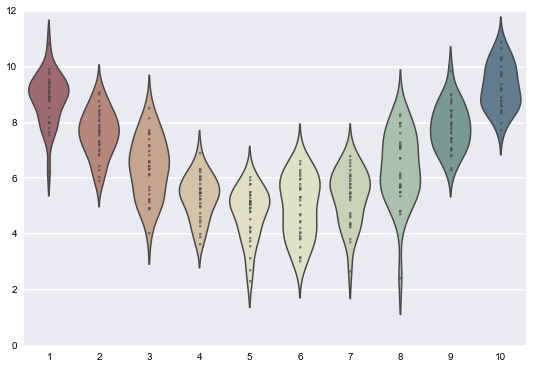

In [39]:
data = randn(30, 10) + np.linspace(-2, 2, 10) ** 2 + 5
palette = sns.color_palette("Spectral", 10, desat=.5)
sns.violin(data, inner="points", color=palette);